In [1]:
import sys
import pandas as pd
sys.path.append('..')

# Подготовка данных

Загрузка данных

In [3]:
xlsx_file = pd.ExcelFile('../input/БОГРАД_PISY.xlsx')
trees = ['pisy_01a', 'pisy_01b', 'pisy_02a', 'pisy_03a', 'pisy_07a', 'pisy_12b', 'pisy_14a']
columns = {_:f'D{__}' if __<16 else f'CWT{__-15}' for _, __ in zip(range(2,32), range(1,31))}
columns[0] = 'Tree'
columns[1] = 'Year'

DELETE:

pisy_01a: mean = 21.34, median = 18.0, mode = 13
pisy_01b: mean = 21.46, median = 18.0, mode = 19
pisy_02a: mean = 28.33, median = 23.0, mode = 17
pisy_03a: mean = 11.30, median = 10.0, mode = 8
pisy_07a: mean = 16.96, median = 16.0, mode = 17
pisy_12b: mean = 18.81, median = 16.0, mode = 16
pisy_14a: mean = 18.95, median = 17.5, mode = 12
 GLOBAL : mean = 19.27, median = 16.0, mode = 11


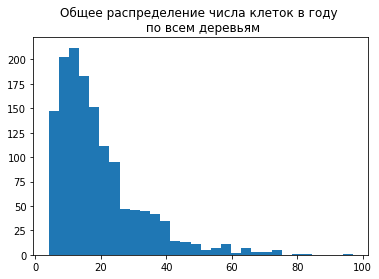

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mode

Ns = dict()
for tree in trees:
    df = xlsx_file.parse(tree)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df = df.dropna(axis=0)
    Ns[tree] = []
    for year in set(df['Год']):
        N = len(df[df['Год']==year])
        if N > 3:
            Ns[tree] += [N]

TOTAL = []
for tree in trees:
    TOTAL += Ns[tree]
    me = np.mean(Ns[tree])
    med = np.median(Ns[tree])
    print(f"{tree}: mean = {me:.2f}, median = {med}, mode = {mode(Ns[tree])[0][0]}")
print(f" GLOBAL : mean = {np.mean(TOTAL):.2f}, median = {np.median(TOTAL)}, mode = {mode(TOTAL)[0][0]}")

plt.hist(TOTAL, bins=30)
plt.title("Общее распределение числа клеток в году \n по всем деревьям")
plt.show()

Функция нормализации трахеид

In [ ]:
def get_normalized_list(x: list, norm : int):
    """
    Функция получения нормированного списка
    :param x: список для нормирования
    :param norm: норма
    :return: l_norm - нормированный к e список l
    """
    l_raw = []  # промежуточный список
    n = len(x)
    for i in range(n):
        for j in range(norm):
            l_raw += [x[i]]
    l_norm = []
    for i in range(norm):
        l_norm += [1 / n * sum([l_raw[j] for j in range(n * i, n * (i + 1))])]
    return l_norm

Нормализуем входные данные

In [ ]:
dataframes = []
for tree in trees:
    df = xlsx_file.parse(tree)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df = df.dropna(axis=0)

    norm_traches = dict()
    for year in set(df['Год']):
        norm_traches[int(year)] = [tree, int(year)] + get_normalized_list(list(df[df['Год']==year]['Dmean']), 15)+ get_normalized_list(list(df[df['Год']==year]['CWTmean']), 15)
    
    dataframes += [pd.DataFrame(norm_traches).transpose().rename(columns=columns).reset_index(drop=True)]

df = pd.concat(dataframes).reset_index(drop=True)

Сохраняем их в .xlsx файл

In [ ]:
df.to_excel('../output/Bograd_PISY_normalized.xlsx', index=False)

Рассчёт средних значений трахеид по годам и по деревьям:

In [ ]:
mean_objects_years = dict()

for year in set(df['Year']):
    temp_data = df[df['Year']==year]
    if len(temp_data) > 3:
        mean_objects_years[year] = temp_data.mean()[1:]


mean_objects_trees = dict()

for tree in set(df['Tree']):
    mean_objects_trees[tree] = df[df['Tree']==tree].mean()[1:]

Считаем средние значения трахеид по всем записям

In [ ]:
global_mean = df.mean()[1:]

Строим таблицы объектов для метода A -- кластеризация отклонений средних объектов по году от среднего глобального объекта:

In [ ]:
quotient_deviation_df_A = []

_columns = {_:f'D{_}' if _<16 else f'CWT{_-15}' for _ in  range(1,31)}
_columns[0] = 'Year'

for year, mean_obj in mean_objects_years.items():
    quotient_deviation_df_A += [[year] + list(mean_obj/global_mean)]

quotient_deviation_df_A = pd.DataFrame(quotient_deviation_df_A).rename(columns=_columns)

In [ ]:
quotient_deviation_df_A.to_excel('../output/quotient_deviation_df_A.xlsx', index=False)

Строим таблицы объектов для метода B -- кластеризация средних отклонений объектов по году от среднего объекта по дереву:

In [ ]:
qd_df_B = []

quotient_deviation_df_B = dict()


for _, row in df.iterrows():
    qd_df_B += [[row[0], row[1]] + list(row[2:] / mean_objects_trees[row[0]])]

qd_df_B = pd.DataFrame(qd_df_B).rename(columns=columns)

for year in set(df['Year']):
    temp_data_q = qd_df_B[qd_df_B['Year']==year]
    if len(temp_data_q) > 3:
        quotient_deviation_df_B[year] = temp_data_q.mean()[1:]

quotient_deviation_df_B = pd.DataFrame(quotient_deviation_df_B).transpose()

In [ ]:
quotient_deviation_df_B.to_excel('../output/quotient_deviation_df_B.xlsx', index=True)